In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from itables import show

from claspy.data_loader import load_tssb_dataset, tssb_dataset_names
from claspy.segmentation import BinaryClaSPSegmentation
from claspy.tests.evaluation import covering

In [2]:
tssb = load_tssb_dataset()
tssb

,dataset,window_size,cps,time_series
0,Adiac,10,"[572, 1012, 1232]","[1.681146, 1.383394, 1.029389, 0.688386, 0.354..."
1,ArrowHead,10,[753],"[-1.957721, -1.858082, -1.657983, -1.420794, -..."
2,Beef,50,[705],"[-0.380818, -0.352238, -0.295392, -0.225041, -..."
3,BeetleFly,10,[1280],"[1.114805, 0.774403, 0.477129, 0.115781, -0.24..."
4,BirdChicken,20,[1280],"[1.697714, 1.439032, 1.22287, 0.99708, 0.76479..."
...,...,...,...,...
70,UWaveGestureLibraryX,10,"[600, 1131, 1652, 2193]","[-0.889766, 0.722005, 0.869297, -0.553167, -0...."
71,UWaveGestureLibraryY,10,"[600, 1131, 1652, 2193]","[-1.523467, -0.106794, 0.190361, 0.979247, 0.3..."
72,UWaveGestureLibraryZ,10,"[600, 1131, 1652, 2193]","[-0.527058, 0.416111, -0.524027, 0.41141, 0.12..."
73,WordSynonyms,10,"[202, 2227]","[-1.183581, -0.514028, -0.480539, -0.394855, -..."


# Setting up the oracle

Function that calculates the covering scores for each time series in the ```tssb``` using ClaSP with the specified distance measure. Options are
- znormed_euclidean_distance
- cinvariant_euclidean_distance
- euclidean_distance

In [3]:
def covering_scores_for_dist(dist: str) -> list[float]:
    cov_scores = []
    for idx, (dataset, window_size, cps, time_series) in list(tssb.iterrows()):
        clasp = BinaryClaSPSegmentation(distance=dist)
        found_cps = clasp.fit_predict(time_series)
        set_score = float(np.round(covering({0: cps}, found_cps, time_series.shape[0]), 5))
        cov_scores.append(set_score)
    return cov_scores

In [4]:
dist_measures = ["znormed_euclidean_distance", "cinvariant_euclidean_distance", "euclidean_distance"]

cov_path = "../data/cov_scores.csv"
if os.path.exists(cov_path):
    df = pd.read_csv(cov_path)
else:
    df = pd.DataFrame()

    for dm in dist_measures:
        scores = covering_scores_for_dist(dm)
        df[dm] = scores

    df.to_csv(cov_path, index=False)
df

,znormed_euclidean_distance,cinvariant_euclidean_distance,euclidean_distance
0,0.80744,0.93578,0.94104
1,0.98550,0.98681,0.98681
2,0.97340,0.80260,0.80260
3,0.97530,0.66069,0.65420
4,0.99377,0.54570,0.54453
...,...,...,...
70,0.98663,0.98734,0.90162
71,0.96282,0.96206,0.95946
72,0.81048,0.79963,0.80961
73,0.72692,0.83742,0.72692


In [5]:
znorm = float(np.round(df["znormed_euclidean_distance"].mean(), 5))
cinv  = float(np.round(df["cinvariant_euclidean_distance"].mean(), 5))
euc   = float(np.round(df["euclidean_distance"].mean(), 5))

znorm, cinv, euc

(0.85508, 0.85808, 0.84063)

Now that we have all scores for each distance measure, we can implement the oracle.

In [6]:
t_oracle = df.idxmax(axis="columns")
t_oracle = t_oracle.to_list()
oracle = dict(zip(tssb_dataset_names, t_oracle))

ds_names = dict(zip(tssb_dataset_names, list(range(len(tssb_dataset_names)))))

ds_names["Adiac"], oracle["Adiac"]

(0, 'euclidean_distance')

In [7]:
def oracle_score(dataset, verbose=False):
    if verbose:
        return df.loc[ds_names[dataset], oracle[dataset]], oracle[dataset]    
    else:
        return df.loc[ds_names[dataset], oracle[dataset]]

oracle_score("Adiac"), oracle_score("Adiac", verbose=True)

(np.float64(0.94104), (np.float64(0.94104), 'euclidean_distance'))

In [8]:
def compare_to_oracle(pred, dist_measure):
    tp = 0.0
    fp = 0.0
    fn = 0.0
    for i in range(len(t_oracle)):
        if pred[i] == dist_measure:
            if pred[i] == t_oracle[i]:
                tp += 1.0
            else:
                fp += 1.0
        else:
            if t_oracle[i] == dist_measure:
                fn += 1.0
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2.0 * precision * recall / (precision + recall)

    return precision, recall, f1

compare_to_oracle(75 * ["euclidean_distance"], "euclidean_distance")

(0.26666666666666666, 1.0, 0.4210526315789474)

In [9]:
optimum = np.empty(len(tssb_dataset_names))
for i, ds in enumerate(tssb_dataset_names):
    optimum[i] = oracle_score(ds)

optimum.mean()

np.float64(0.8928487999999999)

In [10]:
optimum

array([0.94104, 0.98681, 0.9734 , 0.9753 , 0.99377, 0.90001, 0.97935,
       1.     , 0.57749, 0.79315, 0.99402, 0.70618, 0.98719, 0.97566,
       0.98685, 0.98479, 0.86768, 0.94501, 0.76772, 1.     , 0.9744 ,
       0.9949 , 0.41884, 0.57067, 0.89663, 0.97506, 0.91023, 0.99157,
       0.98847, 0.91323, 0.25053, 1.     , 0.99256, 0.35642, 0.71262,
       0.95884, 0.98887, 0.98847, 0.99498, 0.97441, 0.99099, 0.51379,
       0.98641, 0.98907, 0.79698, 0.99497, 1.     , 0.99762, 0.9947 ,
       0.99562, 0.84195, 0.99044, 0.95591, 0.92229, 0.94108, 0.99153,
       0.98736, 1.     , 0.98155, 0.9864 , 0.46682, 0.88291, 0.8822 ,
       0.99362, 0.84985, 0.99097, 0.97366, 0.50099, 1.     , 0.9967 ,
       0.98734, 0.96282, 0.81048, 0.83742, 0.7821 ])

In [11]:
dataset_scores = pd.concat([tssb.dataset, df], axis=1)
dataset_scores

,dataset,znormed_euclidean_distance,cinvariant_euclidean_distance,euclidean_distance
0,Adiac,0.80744,0.93578,0.94104
1,ArrowHead,0.98550,0.98681,0.98681
2,Beef,0.97340,0.80260,0.80260
3,BeetleFly,0.97530,0.66069,0.65420
4,BirdChicken,0.99377,0.54570,0.54453
...,...,...,...,...
70,UWaveGestureLibraryX,0.98663,0.98734,0.90162
71,UWaveGestureLibraryY,0.96282,0.96206,0.95946
72,UWaveGestureLibraryZ,0.81048,0.79963,0.80961
73,WordSynonyms,0.72692,0.83742,0.72692


In [12]:
dataset_scores.znormed_euclidean_distance.mean()

np.float64(0.8550785333333334)

In [13]:
optimum.mean()

np.float64(0.8928487999999999)

In [14]:
def time_series(dataset):
    return tssb.loc[tssb.dataset == dataset].time_series.tolist()[0]

time_series("BeetleFly")

array([1.114805, 0.774403, 0.477129, ..., 0.094708, 0.584328, 1.118003],
      shape=(2560,))

In [15]:
def window_size(dataset):
    return tssb.loc[tssb.dataset == dataset].window_size.tolist()[0]

window_size("Crop")

10

In [16]:
def change_points(dataset):
    return tssb.loc[tssb.dataset == dataset].cps.tolist()[0]

change_points("Adiac")

array([ 572, 1012, 1232])

In [17]:
def sliding_mean_stddev(ts, w_size):
    means = np.zeros(len(ts) - w_size + 1)
    means[0] = float(np.sum(ts[:w_size])) / float(w_size)
    
    var = np.zeros(len(ts) - w_size + 1)
    var[0] = np.sum(np.square(ts[:w_size] - means[0])) / float(w_size)

    for i in range(1, len(ts) - w_size + 1):
        means[i] = means[i - 1] - (ts[i - 1] / w_size) + (ts[i - 1 + w_size] / w_size)
        var[i] = np.sum(np.square(ts[i:i + w_size] - means[i])) / float(w_size)
    return means, np.sqrt(var)

t = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
sliding_mean_stddev(t, 3)

(array([2., 3., 4., 5., 6., 7., 8., 9.]),
 array([0.81649658, 0.81649658, 0.81649658, 0.81649658, 0.81649658,
        0.81649658, 0.81649658, 0.81649658]))

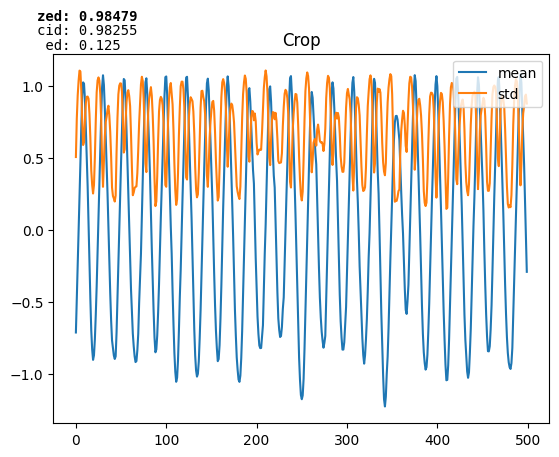

In [18]:
def plot_mean_std_of_series(i, length="auto"):
    dataset, zed, cid, ed = dataset_scores.loc[i].tolist()
    w_size = tssb.loc[i].window_size
    ts = time_series(dataset)
    mu, sigma = sliding_mean_stddev(ts, w_size)

    if length == "auto":
        view_len = int(len(ts) / 3)
    elif length == "full":
        view_len = len(mu)
    else:
        view_len = length

    fig, ax = plt.subplots()
    ax.set_title(dataset)
    ax.plot(mu[:view_len], label="mean")    # in blue
    ax.plot(sigma[:view_len], label="std")  # in orange
    ax.legend(loc="upper right")

    t1 = f"zed: {zed}"
    t2 = f"cid: {cid}"
    t3 = f" ed: {ed}"
    fig.text(0.1, 0.95, t1, family="monospace", fontweight="bold" if zed >= cid and zed >= ed else "normal")
    fig.text(0.1, 0.92, t2, family="monospace", fontweight="bold" if cid >= zed and cid >= ed else "normal")
    fig.text(0.1, 0.89, t3, family="monospace", fontweight="bold" if ed >= zed and ed >= cid else "normal")

plot_mean_std_of_series(15, length=500)

# ZED > ED
### Let's look at some time series for which the z-normalized Euclidean distance significantly outperforms the Euclidean distance.

In [19]:
dataset_scores.loc[[2, 3, 4, 15]]

,dataset,znormed_euclidean_distance,cinvariant_euclidean_distance,euclidean_distance
2,Beef,0.97340,0.80260,0.80260
3,BeetleFly,0.97530,0.66069,0.65420
4,BirdChicken,0.99377,0.54570,0.54453
15,Crop,0.98479,0.98255,0.12500


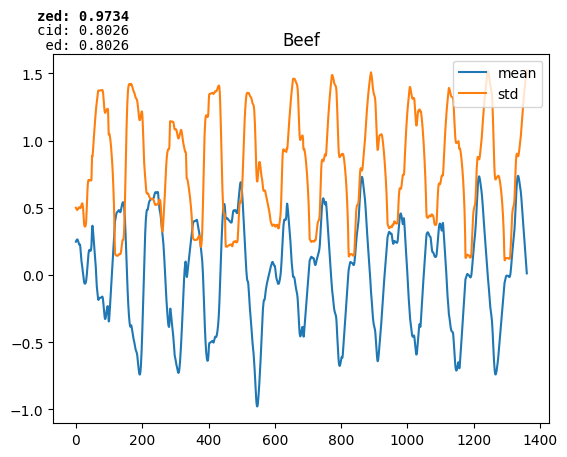

In [20]:
plot_mean_std_of_series(2, length="full")

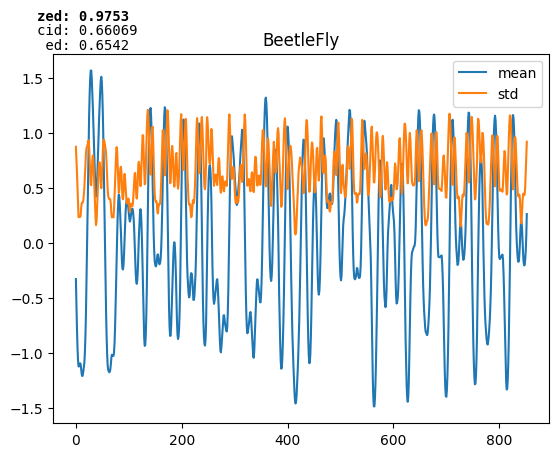

In [21]:
plot_mean_std_of_series(3)

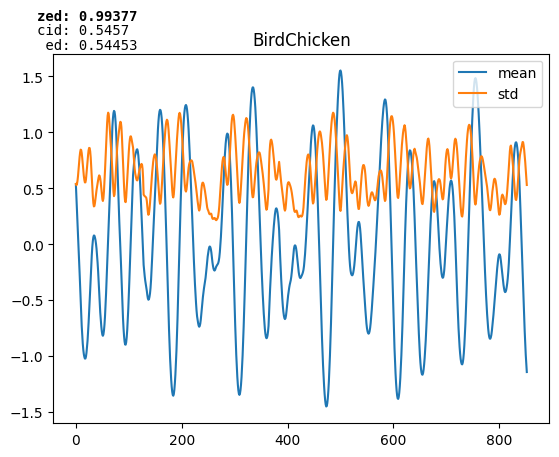

In [22]:
plot_mean_std_of_series(4)

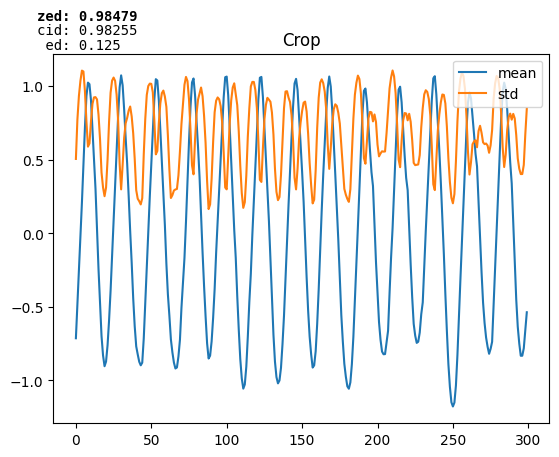

In [23]:
plot_mean_std_of_series(15, length=300)

# ED > ZED
### Let's look at time series for which the Euclidean distance significantly outperforms the z-normalized Euclidean distance.

In [24]:
dataset_scores.loc[[0, 5, 34, 37]]

,dataset,znormed_euclidean_distance,cinvariant_euclidean_distance,euclidean_distance
0,Adiac,0.80744,0.93578,0.94104
5,Car,0.74170,0.89041,0.90001
34,InlineSkate,0.48637,0.71215,0.71262
37,LargeKitchenAppliances,0.65057,0.98847,0.97339


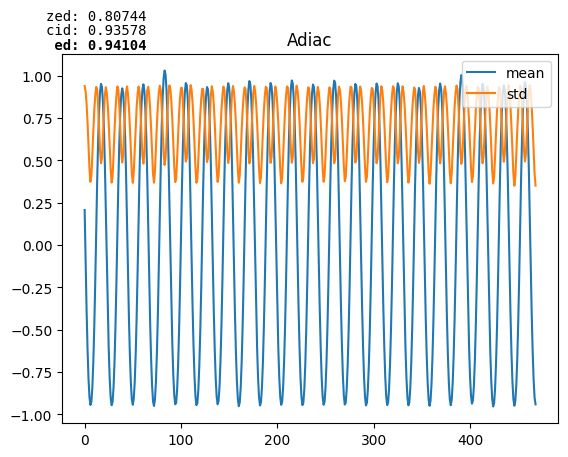

In [25]:
plot_mean_std_of_series(0)

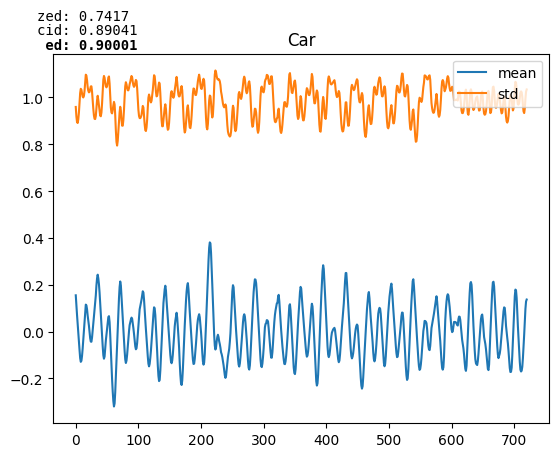

In [26]:
plot_mean_std_of_series(5)

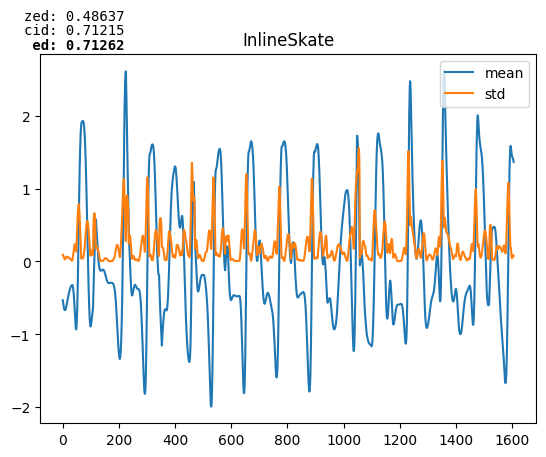

In [27]:
plot_mean_std_of_series(34)

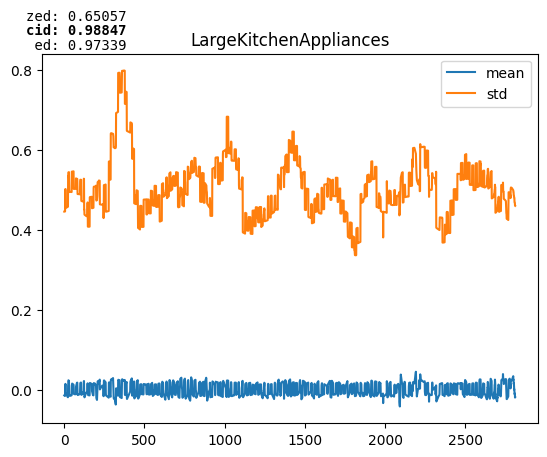

In [28]:
plot_mean_std_of_series(37)

# Finding a decision boundary
Based on the mean and the standard deviation of each window, we want to find a decision boundary.

In [29]:
def evaluate_picks(picks):
    scores = []
    for idx, d in enumerate(picks):
        if d == "zed":
            scores.append(dataset_scores.loc[idx].znormed_euclidean_distance)
        elif d == "cid":
            scores.append(dataset_scores.loc[idx].cinvariant_euclidean_distance)
        elif d == "ed":
            scores.append(dataset_scores.loc[idx].euclidean_distance)
        else:
            raise RuntimeError(f"Not a valid distance measure at idx {idx}.\n")
    return np.mean(scores)

evaluate_picks(75 * ["zed"])

np.float64(0.8550785333333334)

### Standard deviation of the means and stds of all windows.

In [30]:
def mean_std_spread(dataset, w_size):
    ts = time_series(dataset)
    mu  = np.mean(ts)
    std = np.std(ts)
    nts = (ts - mu) / std

    means = []
    stds = []
    for i in range(len(nts) - w_size + 1):
        segment = nts[i:i + w_size]
        means.append(np.mean(segment))
        stds.append(np.std(segment))

    return np.std(means), np.std(stds)

mean_std_spread("Adiac", 10)

(np.float64(0.6885175826364351), np.float64(0.20144750146579174))

In [31]:
mu_spreads = []
o_spreads = []
for dataset in tssb_dataset_names:
    w_size = window_size(dataset)
    mu_spread, o_spread = mean_std_spread(dataset, w_size)
    mu_spreads.append(mu_spread)
    o_spreads.append(o_spread)

spread = pd.DataFrame({"dataset" : tssb_dataset_names, "std_of_means" : mu_spreads, "std_of_stds" : o_spreads, "dist_measure" : t_oracle})
spread

,dataset,std_of_means,std_of_stds,dist_measure
0,Adiac,0.688518,0.201448,euclidean_distance
1,ArrowHead,0.794997,0.248390,cinvariant_euclidean_distance
2,Beef,0.393483,0.405495,znormed_euclidean_distance
3,BeetleFly,0.695498,0.231563,znormed_euclidean_distance
4,BirdChicken,0.710285,0.263011,znormed_euclidean_distance
...,...,...,...,...
70,UWaveGestureLibraryX,0.111996,0.200789,cinvariant_euclidean_distance
71,UWaveGestureLibraryY,0.102533,0.104560,znormed_euclidean_distance
72,UWaveGestureLibraryZ,0.115259,0.165473,znormed_euclidean_distance
73,WordSynonyms,0.490633,0.400304,cinvariant_euclidean_distance


In [32]:
zed_mu_spread = spread.loc[spread.dist_measure == "znormed_euclidean_distance"].std_of_means.mean()
cid_mu_spread = spread.loc[spread.dist_measure == "cinvariant_euclidean_distance"].std_of_means.mean()
ed_mu_spread  = spread.loc[spread.dist_measure == "euclidean_distance"].std_of_means.mean()

zed_mu_spread, cid_mu_spread, ed_mu_spread

(np.float64(0.5270854683690077),
 np.float64(0.4007954946404902),
 np.float64(0.4968971564660959))

In [33]:
zed_o_spread = spread.loc[spread.dist_measure == "znormed_euclidean_distance"].std_of_stds.mean()
cid_o_spread = spread.loc[spread.dist_measure == "cinvariant_euclidean_distance"].std_of_stds.mean()
ed_o_spread  = spread.loc[spread.dist_measure == "euclidean_distance"].std_of_stds.mean()

zed_o_spread, cid_o_spread, ed_o_spread

(np.float64(0.2696549638391937),
 np.float64(0.3136239647522756),
 np.float64(0.278034209815316))

In [34]:
dataset_scores.znormed_euclidean_distance.mean()

np.float64(0.8550785333333334)

In [35]:
dataset_scores.cinvariant_euclidean_distance.mean()

np.float64(0.8580790666666667)

In [36]:
dataset_scores.euclidean_distance.mean()

np.float64(0.8406263999999999)

(np.float64(0.25), np.float64(0.8691753333333334))
(np.float64(0.26), np.float64(0.8690988000000001))
(np.float64(0.27), np.float64(0.8708937333333334))
(np.float64(0.28), np.float64(0.8708937333333334))
(np.float64(0.29), np.float64(0.8710608)) <-- maximum
(np.float64(0.3), np.float64(0.8703921333333333))
(np.float64(0.31), np.float64(0.8703921333333333))
(np.float64(0.32), np.float64(0.8700972))
(np.float64(0.33), np.float64(0.8700972))
(np.float64(0.34), np.float64(0.8700972))


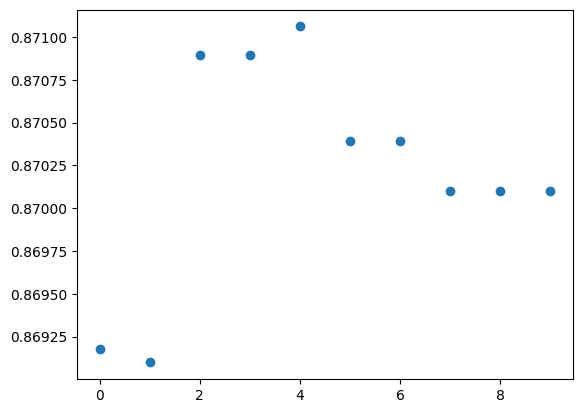

In [37]:
threshhold_covering_scores = []
r = np.arange(0.25, 0.35, 0.01)
for mu_threshhold in r:
    picks = []
    for idx, (dataset, std_mu, std_o, dm) in spread.iterrows():
        if std_mu <= mu_threshhold:
            picks.append("cid")
        else:
            picks.append("zed")
    cov = evaluate_picks(picks)
    threshhold_covering_scores.append(cov)

for e in zip(np.round(r, 2), threshhold_covering_scores):
    if e[1] == np.max(threshhold_covering_scores):
        print(e, "<-- maximum")
    else:
        print(e)
plt.plot(threshhold_covering_scores, "o")

In [38]:
optimum.mean()

np.float64(0.8928487999999999)

In [39]:
dataset_scores.znormed_euclidean_distance.mean()

np.float64(0.8550785333333334)

In [40]:
np.max(threshhold_covering_scores)

np.float64(0.8710608)

A threshhold of `0.29` for the standard deviation of means of the windows yields the best covering score of around `0.871`, improving the score by around `1.58%` compared to the default znormed_euclidean_distance measure.

# Let's look at the distribution of distances

In [41]:
# from claspy.nearest_neighbour import KSubsequenceNeighbours
# zed_ksn = KSubsequenceNeighbours(k_neighbours=1, distance="znormed_euclidean_distance")
# cid_ksn = KSubsequenceNeighbours(k_neighbours=1, distance="cinvariant_euclidean_distance")
# ed_ksn  = KSubsequenceNeighbours(k_neighbours=1, distance="euclidean_distance")

# ksns = [zed_ksn, cid_ksn, ed_ksn]
# for idx, ksn in enumerate(ksns):
#     dm = "placeholder"
#     if idx == 0:
#         dm = "zed"
#     elif idx == 1:        
#         dm = "cid"
#     else:
#         dm = "ed"
    
#     for dataset in tssb_dataset_names:
#         path = f"../plots/distance-distributions/{dataset}/{dataset}-{dm}.png"
#         ksn.fit(time_series(dataset))

#         fig, ax = plt.subplots()
#         _ = ax.hist(ksn.distances, bins=20)
#         _ = fig.text(0.1, 0.95, "Dataset: " + dataset, family="monospace", fontweight="bold")
#         _ = fig.text(0.1, 0.90, "Distance: " + dm, family="monospace", fontweight="bold")
#         _ = plt.savefig(path)
#         plt.close(fig)

In [42]:
from matplotlib.image import imread

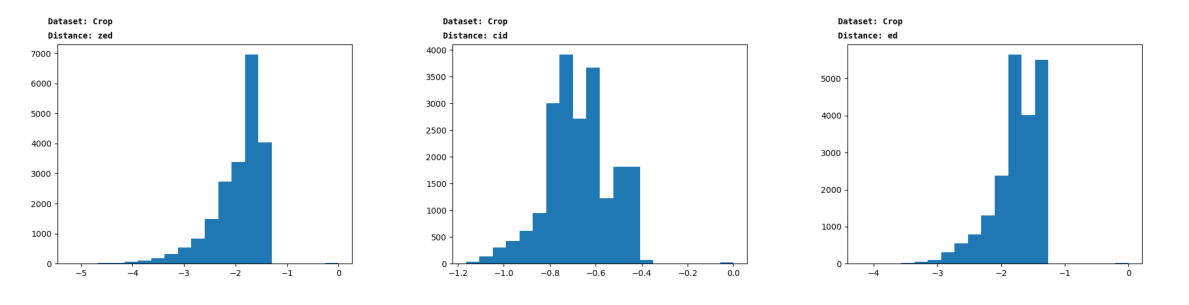

In [43]:
dataset = "Crop"
path = f"../plots/distance-distributions/{dataset}/"
img_zed = imread(path + f"{dataset}-zed.png")
img_cid = imread(path + f"{dataset}-cid.png")
img_ed  = imread(path + f"{dataset}-ed.png")

fig, ax = plt.subplots(1, 3, figsize=(12,4))
ax[0].imshow(img_zed)
ax[1].imshow(img_cid)
ax[2].imshow(img_ed)
for a in ax:
    a.axis("off")

plt.tight_layout()

All distances are negative due to z-normalization that is performed in claspy's `_knn` function in the `nearest_neighbour` module. Since we only consider the 1-NN distances here, meaning the distance to the closest window, the distance is guarenteed to be less than the mean of all distances, making it negative after normalization.

In [44]:
from claspy.nearest_neighbour import KSubsequenceNeighbours
from joblib import Memory
cache_dir = "../cache"
memory = Memory(cache_dir, verbose=0)

In [45]:
@memory.cache
def distances_dataframe():
    dists_dm = []
    for dm in dist_measures:
        dists = []
        for dataset in tssb_dataset_names:
            ksn = KSubsequenceNeighbours(k_neighbours=1, window_size=window_size(dataset), distance=dm)
            ksn.fit(time_series(dataset))

            dists.append(ksn.distances.ravel())
        dists_dm.append(dists)

    names = pd.Series(tssb_dataset_names)
    dists_zed = pd.Series(dists_dm[0])
    dists_cid = pd.Series(dists_dm[1])
    dists_ed = pd.Series(dists_dm[2])

    return pd.DataFrame({"dataset" : names, dist_measures[0] : dists_zed, dist_measures[1] : dists_cid, dist_measures[2] : dists_ed})

one_nn_distances = distances_dataframe()
one_nn_distances

,dataset,znormed_euclidean_distance,cinvariant_euclidean_distance,euclidean_distance
0,Adiac,"[-1.1922459881472567, -1.1911004101855225, -1....","[-1.492516041706413, -1.5594059552362403, -1.4...","[-1.5248614127366344, -1.4785027694105721, -1...."
1,ArrowHead,"[-1.2270714340126956, -1.2192623014458082, -1....","[-0.28467882184400267, -0.3044103129587974, -0...","[-1.6097312245856052, -1.663766109955468, -1.6..."
2,Beef,"[-2.1016134224344385, -2.094951256861192, -2.0...","[-0.7239063974955477, -0.7350526909255594, -0....","[-1.3701750410782139, -1.3982549757824587, -1...."
3,BeetleFly,"[-1.3660758870217626, -1.3753625258466342, -1....","[-0.9820217873149905, -0.9380971448182669, -0....","[-1.3627699396822195, -1.276517063628781, -1.2..."
4,BirdChicken,"[-1.32317733214793, -1.3083711964162121, -1.29...","[-0.8882298306644192, -0.9077973798054612, -0....","[-1.3072279823693957, -1.3010912625179472, -1...."
...,...,...,...,...
70,UWaveGestureLibraryX,"[-1.9770639174790565, -1.9471180040734626, -1....","[-1.5265669481570443, -1.4281695531230025, -1....","[-1.7793981258767098, -1.7384209119380594, -1...."
71,UWaveGestureLibraryY,"[-1.9053429648190614, -1.8448966405748874, -1....","[-1.636034222251745, -1.6726172866044682, -1.6...","[-1.8758518030469022, -1.8014740802255744, -1...."
72,UWaveGestureLibraryZ,"[-2.578649399427894, -2.681384274432914, -2.54...","[-2.048332694866686, -1.9707151513810672, -1.9...","[-2.3802055245926845, -2.4494682501418206, -2...."
73,WordSynonyms,"[-1.8070578229429537, -1.6421247503168404, -2....","[-0.22709928241357852, -0.19655554624732288, -...","[-1.2752967123028462, -1.334050792181106, -1.5..."


In [46]:
from scipy.stats import skew, kurtosis

In [47]:
def apply_to_distances(func):
    out = []
    for col in one_nn_distances.columns[1:]:
        vals = []
        for i in range(one_nn_distances.shape[0]):
            distances = one_nn_distances[col].loc[i]        
            vals.append(func(distances))
        out.append(vals)
    return out

In [48]:
mu_zed, mu_cid, mu_ed = apply_to_distances(np.mean)
o_zed,   o_cid,  o_ed = apply_to_distances(np.std)
sk_zed, sk_cid, sk_ed = apply_to_distances(skew)
k_zed,   k_cid,  k_ed = apply_to_distances(kurtosis)

In [49]:
np.mean(mu_zed), np.mean(mu_cid), np.mean(mu_ed)

(np.float64(-2.110142041447087),
 np.float64(-0.8933889672181425),
 np.float64(-1.712333551556268))

In [50]:
np.mean(o_zed), np.mean(o_cid), np.mean(o_ed)

(np.float64(0.4173029540512879),
 np.float64(0.17712548454893187),
 np.float64(0.32584580396503166))

In [51]:
np.mean(sk_zed), np.mean(sk_cid), np.mean(sk_ed)

(np.float64(-1.052096283618922),
 np.float64(-0.31752285779325695),
 np.float64(-0.5054970722972605))

In [52]:
np.mean(k_zed), np.mean(k_cid), np.mean(k_ed)

(np.float64(13.54918580402372),
 np.float64(7.161093948580585),
 np.float64(7.111402460723669))

In [53]:
def plot_sum_stats(a, b, c, title=""):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
    fig.suptitle(title)
    ax[0].plot(np.sort(a))
    ax[1].plot(np.sort(b))
    ax[2].plot(np.sort(c))

    plt.tight_layout()

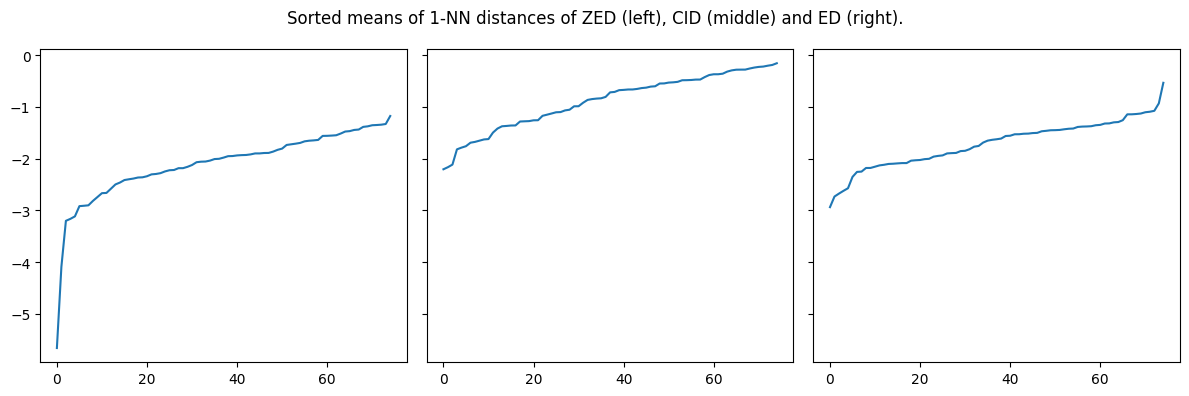

In [54]:
plot_sum_stats(mu_zed, mu_cid, mu_ed, "Sorted means of 1-NN distances of ZED (left), CID (middle) and ED (right).")

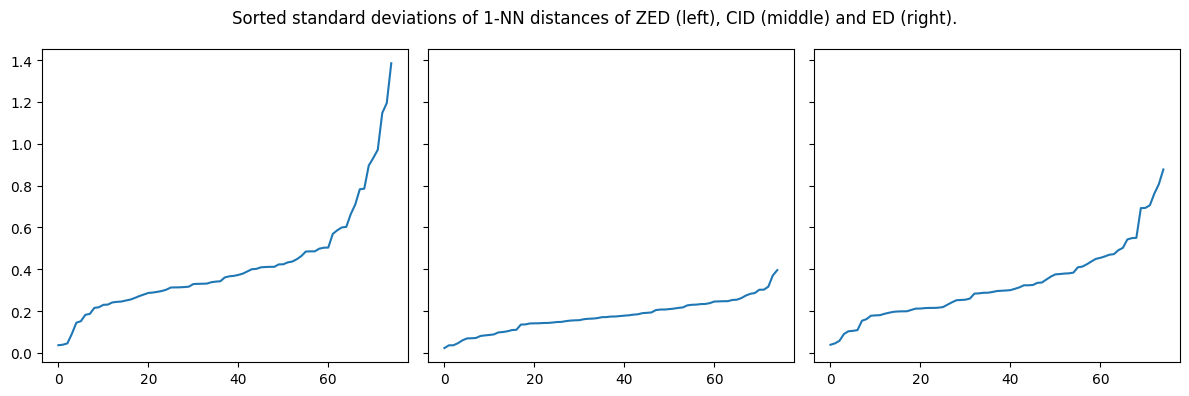

In [55]:
plot_sum_stats(o_zed, o_cid, o_ed, "Sorted standard deviations of 1-NN distances of ZED (left), CID (middle) and ED (right).")

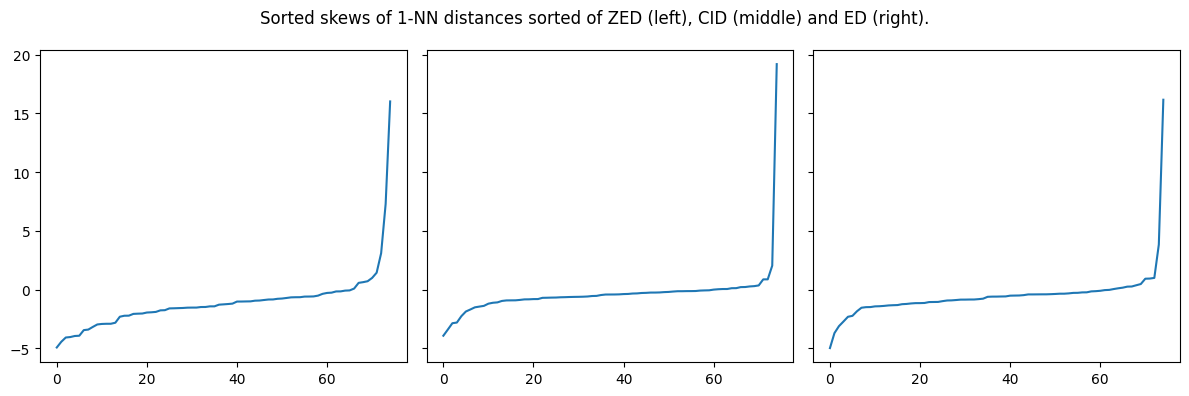

In [56]:
plot_sum_stats(sk_zed, sk_cid, sk_ed, "Sorted skews of 1-NN distances sorted of ZED (left), CID (middle) and ED (right).")

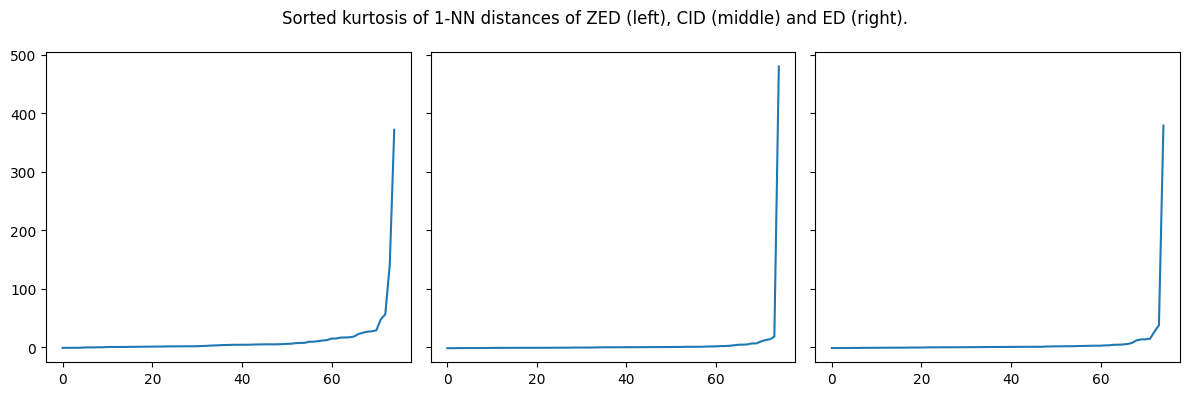

In [57]:
plot_sum_stats(k_zed, k_cid, k_ed, "Sorted kurtosis of 1-NN distances of ZED (left), CID (middle) and ED (right).")

In [58]:
change_points("DistalPhalanxOutlineAgeGroup")

array([300])

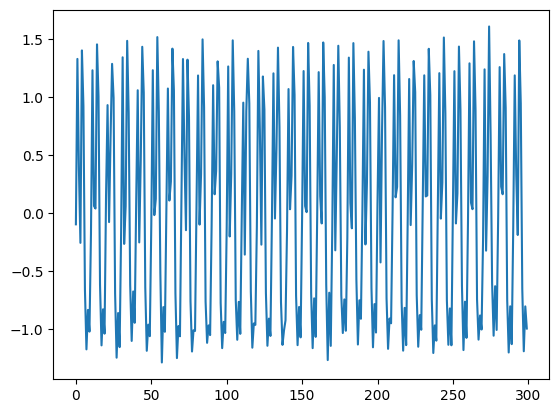

In [59]:
plt.plot(time_series("DistalPhalanxOutlineAgeGroup")[:300])

In [61]:
idx = 11
dataset_scores.loc[idx]

dataset                          Computers
znormed_euclidean_distance             0.5
cinvariant_euclidean_distance      0.70618
euclidean_distance                 0.57669
Name: 11, dtype: object

In [62]:
change_points(tssb_dataset_names[idx])

array([5625])

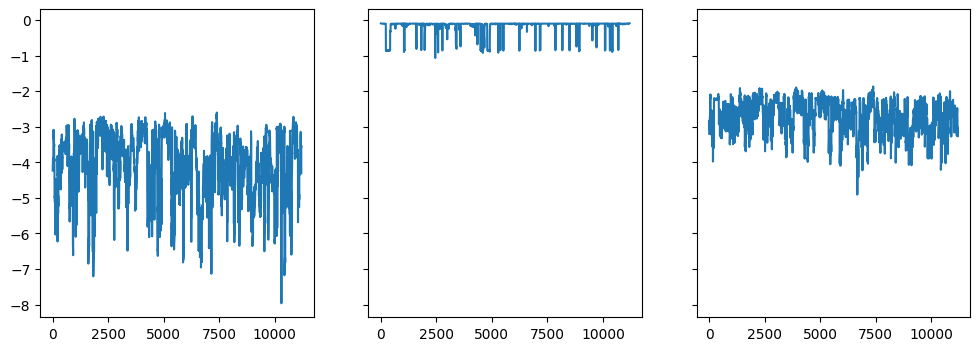

In [63]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
ax[0].plot(one_nn_distances.loc[idx].znormed_euclidean_distance)
ax[1].plot(one_nn_distances.loc[idx].cinvariant_euclidean_distance)
ax[2].plot(one_nn_distances.loc[idx].euclidean_distance)

# A different view

In [64]:
def map_vector_diff_to_plane(v1, v2):
    w = v1 - v2
    V = np.array([v1, v2]).T
    Q, _ = np.linalg.qr(V)
    return Q.T @ w

map_vector_diff_to_plane(np.array([1, 0, 0]), np.array([1, 1, 0]))

array([ 0., -1.])

In [65]:
def z_normalize(w):
    return (w - np.mean(w)) / np.std(w)

z_normalize(np.array([1, 23, 6, 2, 532, 12, 7, 4]))

array([-0.41722159, -0.29039775, -0.38839799, -0.41145687,  2.64384457,
       -0.35380967, -0.38263327, -0.39992743])

In [66]:
def windows(ts, w_size, normalize=False):
    windows = []
    for i in range(len(ts) - w_size + 1):
        if normalize:
            windows.append(z_normalize(ts[i:i+w_size]))
        else:
            windows.append(ts[i:i+w_size])
    return np.array(windows)

windows(time_series("Adiac")[:10], 5), windows(time_series("Adiac")[:10], 5, normalize=True)

(array([[ 1.681146,  1.383394,  1.029389,  0.688386,  0.354835],
        [ 1.383394,  1.029389,  0.688386,  0.354835,  0.012664],
        [ 1.029389,  0.688386,  0.354835,  0.012664, -0.317504],
        [ 0.688386,  0.354835,  0.012664, -0.317504, -0.638269],
        [ 0.354835,  0.012664, -0.317504, -0.638269, -0.935649],
        [ 0.012664, -0.317504, -0.638269, -0.935649, -1.201327]]),
 array([[ 1.38036858,  0.75164371,  0.00413657, -0.71591591, -1.42023295],
        [ 1.42750877,  0.69476372, -0.01106885, -0.70147673, -1.40972691],
        [ 1.41824999,  0.70265002,  0.0026882 , -0.71536283, -1.40822538],
        [ 1.42099874,  0.7118405 , -0.01564459, -0.71761028, -1.39958437],
        [ 1.44268512,  0.69430679, -0.0278192 , -0.72937945, -1.37979326],
        [ 1.45803481,  0.69231032, -0.05160676, -0.74128943, -1.35744894]]))

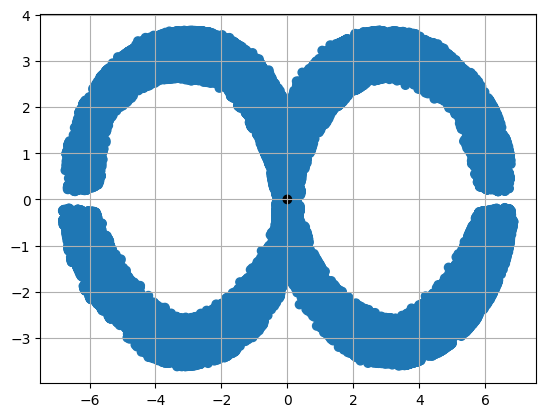

In [67]:
i = 0
w = windows(time_series("Adiac")[i:i+1000], 10)

vectors = [[1, 1],
           [-1, 1],
           [1, -1],
           [-1, -1]]

for i in range(len(w)):
    for j in range(i + 1, len(w)):
        dst = map_vector_diff_to_plane(w[i, :], w[j, :])
        vectors.append(dst.tolist())

vectors.append([0, 0])
vectors = np.array(vectors)

c = 4 * ["w"] + (len(vectors) - 5) * ["#1f77b4"] + ["black"]
plt.grid(True)
plt.scatter(vectors[:, 0], vectors[:, 1], color=c)

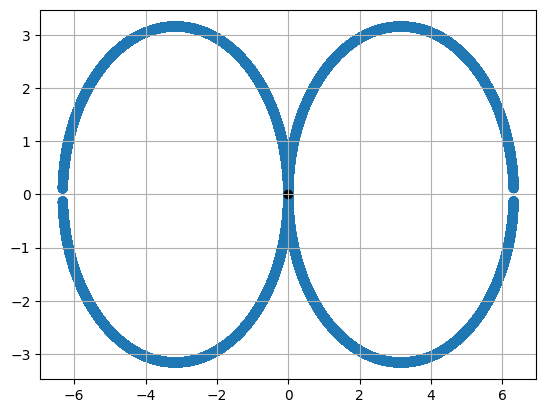

In [68]:
i = 0
w = windows(time_series("Adiac")[i:i+1000], 10, normalize=True)

vectors = [[1, 1],
           [-1, 1],
           [1, -1],
           [-1, -1]]

for i in range(len(w)):
    for j in range(i + 1, len(w)):
        dst = map_vector_diff_to_plane(w[i, :], w[j, :])
        vectors.append(dst.tolist())

vectors.append([0, 0])
vectors = np.array(vectors)

c = 4 * ["w"] + (len(vectors) - 5) * ["#1f77b4"] + ["black"]
plt.grid(True)
plt.scatter(vectors[:, 0], vectors[:, 1], color=c)